In [2]:
import numpy as np
import cv2
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import statsmodels.stats.multitest as smm

from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu

In [72]:
# 删除离群点
def remove_outliers(df, multiplier=1.5):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    return df[~((df < (Q1 - multiplier * IQR)) | (df > (Q3 + multiplier * IQR))).any(axis=1)]


def loadcsv(loadpath, stain_type):
    if loadpath=="Feature_image":
        loadpath_RETT = f"{loadpath}/features_VPA_{stain_type}.csv"
        loadpath_CTRL = f"{loadpath}/features_Ctrl_{stain_type}.csv"
    elif loadpath=="Feature_GradCAM":
        loadpath_RETT = f"{loadpath}/features_VPA_{stain_type}_Resnet10_noavg_GradCAM.csv"
        loadpath_CTRL = f"{loadpath}/features_Ctrl_{stain_type}_Resnet10_noavg_GradCAM.csv"
    elif loadpath=="Feature_ScoreCAM":
        loadpath_RETT = f"{loadpath}/features_VPA_{stain_type}_Resnet10_noavg_ScoreCAM.csv"
        loadpath_CTRL = f"{loadpath}/features_Ctrl_{stain_type}_Resnet10_noavg_ScoreCAM.csv"
    else:
        print(f"Load Failed, can not find {loadpath}")
    # 定义你想要读取的列的索引，注意 Python 索引从 0 开始
    columns_to_use = [10] + list(range(12, 19)) + list(range(20, 22)) + list(range(36, 99))
    # 读取 CSV 文件时仅加载指定的列
    df_RETT = pd.read_csv(loadpath_RETT, usecols=columns_to_use).dropna()  # 删除包含 NaN 的样本
    df_CTRL = pd.read_csv(loadpath_CTRL, usecols=columns_to_use).dropna()  # 删除包含 NaN 的样本
    print(f"🦠 LOAD {loadpath_RETT} {df_RETT.shape}")
    print(f"🧫 LOAD {loadpath_CTRL} {df_CTRL.shape}")
    
#     # 删除离群点
#     df_RETT_filtered = remove_outliers(df_RETT_scaled, multiplier=2)
#     df_CTRL_filtered = remove_outliers(df_CTRL_scaled, multiplier=2)
#     print(f"remove outliers {df_RETT_filtered.shape}, {df_CTRL_filtered.shape}")

#   添加状态标签
    df_RETT['State'] = 'RETT'
    df_CTRL['State'] = 'CTRL'
    
    # 合并数据
    df_combined = pd.concat([df_CTRL, df_RETT])
    
    return df_combined, df_RETT, df_CTRL

In [ ]:
def loadcsv_Standard(loadpath, stain_type):
    if loadpath=="Feature_image":
        loadpath_RETT = f"{loadpath}/features_VPA_{stain_type}.csv"
        loadpath_CTRL = f"{loadpath}/features_Ctrl_{stain_type}.csv"
    elif loadpath=="Feature_GradCAM":
        loadpath_RETT = f"{loadpath}/features_VPA_{stain_type}_Resnet10_noavg_GradCAM.csv"
        loadpath_CTRL = f"{loadpath}/features_Ctrl_{stain_type}_Resnet10_noavg_GradCAM.csv"
    elif loadpath=="Feature_ScoreCAM":
        loadpath_RETT = f"{loadpath}/features_VPA_{stain_type}_Resnet10_noavg_ScoreCAM.csv"
        loadpath_CTRL = f"{loadpath}/features_Ctrl_{stain_type}_Resnet10_noavg_ScoreCAM.csv"
    else:
        print(f"Load Failed, can not find {loadpath}")
        
    # 定义你想要读取的列的索引，注意 Python 索引从 0 开始
    columns_to_use = [10] + list(range(12, 19)) + list(range(20, 22)) + list(range(36, 99))
    # 读取 CSV 文件时仅加载指定的列
    df_RETT = pd.read_csv(loadpath_RETT, usecols=columns_to_use).dropna()  # 删除包含 NaN 的样本
    df_CTRL = pd.read_csv(loadpath_CTRL, usecols=columns_to_use).dropna()  # 删除包含 NaN 的样本
    print(f"🦠 LOAD {loadpath_RETT} {df_RETT.shape}")
    print(f"🧫 LOAD {loadpath_CTRL} {df_CTRL.shape}")
    
    # 标准化数据
    scaler = StandardScaler()
    df_RETT_scaled = scaler.fit_transform(df_RETT)
    df_CTRL_scaled = scaler.fit_transform(df_CTRL)
    # 将标准化后的数据转换回 DataFrame
    df_RETT_scaled = pd.DataFrame(df_RETT_scaled, columns=df_RETT.columns)
    df_CTRL_scaled = pd.DataFrame(df_CTRL_scaled, columns=df_CTRL.columns)

    # 添加状态标签
    df_RETT = df_RETT_scaled.copy()
    df_CTRL = df_CTRL_scaled.copy()
    df_RETT['State'] = 'RETT'
    df_CTRL['State'] = 'CTRL'
    
    # 合并数据
    df_combined = pd.concat([df_CTRL, df_RETT])


    # 合并数据
    df_combined = pd.concat([df_CTRL, df_RETT])
    
    return df_combined, df_RETT, df_CTRL

In [73]:
loadpath = "Feature_image"
stain_type = "H3K27ac"
savename = f"Feature_{stain_type}"

df_combined, df_RETT, df_CTRL = loadcsv(loadpath, stain_type)

features = df_CTRL.columns.tolist()
for i in range(len(features)):
    print(i, features[i])
    
print("len(features): ", len(features))
df_combined

####################  🦠 Feature_image/features_RETT_H3K27ac.csv   ####################
####################  🧫 Feature_image/features_CTRL_H3K27ac.csv   ####################
load csv (3595, 73), (1723, 73)
0 Size.Area
1 Size.MajorAxisLength
2 Size.MinorAxisLength
3 Size.Perimeter
4 Shape.Circularity
5 Shape.Eccentricity
6 Shape.EquivalentDiameter
7 Shape.Extent
8 Shape.MinorMajorAxisRatio
9 Shape.Solidity
10 Shape.FSD1
11 Shape.FSD2
12 Shape.FSD3
13 Shape.FSD4
14 Shape.FSD5
15 Shape.FSD6
16 Nucleus.Intensity.Min
17 Nucleus.Intensity.Max
18 Nucleus.Intensity.Mean
19 Nucleus.Intensity.Median
20 Nucleus.Intensity.MeanMedianDiff
21 Nucleus.Intensity.Std
22 Nucleus.Intensity.IQR
23 Nucleus.Intensity.MAD
24 Nucleus.Intensity.Skewness
25 Nucleus.Intensity.Kurtosis
26 Nucleus.Intensity.HistEnergy
27 Nucleus.Intensity.HistEntropy
28 Nucleus.Gradient.Mag.Mean
29 Nucleus.Gradient.Mag.Std
30 Nucleus.Gradient.Mag.Skewness
31 Nucleus.Gradient.Mag.Kurtosis
32 Nucleus.Gradient.Mag.HistEntropy
33 Nucle

,Size.Area,Size.MajorAxisLength,Size.MinorAxisLength,Size.Perimeter,Shape.Circularity,Shape.Eccentricity,Shape.EquivalentDiameter,Shape.Extent,Shape.MinorMajorAxisRatio,Shape.Solidity,...,Intensity.part04,Intensity.part03,Intensity.part02,Intensity.part01,Intensity.distribution.part05,Intensity.distribution.part04,Intensity.distribution.part03,Intensity.distribution.part02,Intensity.distribution.part01,State
0,38948.0,277.440968,187.541394,799.737157,0.765245,0.736930,222.688423,0.668039,0.675969,0.964298,...,13.700211,13.068205,12.506310,12.287821,0.232869,0.203827,0.194424,0.186065,0.182814,CTRL
1,42887.0,246.549569,222.685646,788.506709,0.866812,0.429202,233.678036,0.729991,0.903208,0.990599,...,26.153398,25.924641,24.587092,20.862814,0.214575,0.210622,0.208780,0.198008,0.168015,CTRL
2,28540.0,207.622145,175.893498,639.470129,0.877048,0.531305,190.625960,0.773987,0.847181,0.990869,...,25.206957,25.518655,25.373867,26.939791,0.184934,0.199393,0.201859,0.200714,0.213101,CTRL
3,21662.0,188.845307,147.394722,566.256926,0.848949,0.625149,166.075028,0.741265,0.780505,0.987329,...,28.805203,26.828498,25.424779,25.075319,0.202739,0.216380,0.201532,0.190987,0.188362,CTRL
4,40446.0,290.127228,178.573957,790.080303,0.814222,0.788135,226.930489,0.735516,0.615502,0.989916,...,31.137090,28.849764,28.194233,27.339926,0.194117,0.217215,0.201258,0.196685,0.190725,CTRL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3590,37307.0,278.129667,173.833075,766.884343,0.797151,0.780619,217.946663,0.767729,0.625007,0.987506,...,22.632874,20.944392,20.014308,20.953209,0.220381,0.208706,0.193136,0.184559,0.193217,RETT
3591,59634.0,372.976981,209.742620,1091.986940,0.628447,0.826901,275.551024,0.687646,0.562347,0.942875,...,27.448870,26.257785,26.984785,27.842437,0.191789,0.204402,0.195532,0.200946,0.207332,RETT
3592,23753.0,215.864035,144.384424,623.487373,0.767844,0.743382,173.905891,0.726836,0.668867,0.979061,...,32.076669,31.295849,31.308607,32.933333,0.202896,0.200357,0.195480,0.195559,0.205708,RETT
3593,20367.0,193.239746,137.550162,572.274170,0.781499,0.702371,161.034375,0.767986,0.711811,0.959847,...,26.246367,26.830408,26.367197,25.755202,0.197864,0.200127,0.204580,0.201048,0.196382,RETT


In [8]:
from sklearn.decomposition import PCA

def validate_pca(df_combined, df_RETT, df_CTRL, loadpath, savename):
    print("📊 PCA")
    # 提取特征数据
    features = df_combined.drop('State', axis=1)

    # 应用 PCA
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(features)
    principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])

    # 计算贡献率
    explained_variance_ratio = pca.explained_variance_ratio_
    print("Explained variance ratio:", explained_variance_ratio)

    # 获取加载矩阵
    loading_matrix = pca.components_.T
    loading_df = pd.DataFrame(loading_matrix, columns=['PC1', 'PC2'], index=features.columns)

    # 可视化加载矩阵
    plt.figure(figsize=(16, 12))
    sns.heatmap(loading_df, annot=True, cmap='coolwarm')
    plt.title('PCA Loading Matrix')
    plt.savefig(f'{loadpath}/{savename}_PCA_Matrix.png', dpi=300)
    plt.show()

    # 重置索引以确保对齐
    state_df = df_combined[['State']].reset_index(drop=True)
    finalDf = pd.concat([principalDf, state_df], axis=1)

    # 使用 Seaborn 绘制 PCA 结果图
    sns.scatterplot(data=finalDf, x='principal component 1', y='principal component 2', hue='State')
    plt.title('PCA of Dataset by State')
    plt.savefig(f'{loadpath}/{savename}_PCA.png', dpi=300)
    plt.show()

In [61]:
from scipy.stats import ttest_ind

def validate_ttest(df_combined, df_RETT, df_CTRL, loadpath, savename):
    print("📊 ttest")
    # 初始化存储 p 值的列表
    p_values = []

    # 进行 t-检验
    for column in df_CTRL.columns[:-1]:  # 忽略 'State' 列
        t_stat, p_val = ttest_ind(
            df_CTRL[column], 
            df_RETT[column],
            equal_var=False  # 可以假设不等方差
        )
        p_values.append((column, p_val))

    # 将 p 值转化为 DataFrame
    p_values_df = pd.DataFrame(p_values, columns=['Feature', 'p_value'])

    # 提取原始 p 值列表
    p_values_list = p_values_df['p_value'].tolist()

    # 进行校正
    rej, pval_corr = smm.multipletests(p_values_list, alpha=0.05, method='fdr_bh')[:2]

    # 将校正后的 p 值添加回 DataFrame
    p_values_df['p_corrected'] = pval_corr

    # 筛选显著特征（例如校正后 p < 0.02）
    significant_features = p_values_df[p_values_df['p_corrected'] < 0.02]

    # 按 p 值排序
    significant_features = significant_features.sort_values(by='p_corrected')
    significant_features = pd.DataFrame(significant_features)
    
    # 打印 DataFrame
    print("significant_features: ", len(significant_features))
    print(significant_features.to_string(index=False))

    # 可视化显著特征的 p 值
    plt.figure(figsize=(16, 10))
    sns.barplot(x='p_corrected', y='Feature', data=significant_features, palette='viridis')
    plt.title('Significant Features Differentiating CTRL and RETT')
    plt.xlabel('p_value_corrected')
    plt.ylabel('Features')
    plt.axvline(x=0.02, color='r', linestyle='--')
    plt.savefig(f'{loadpath}/{savename}_ttest.png', dpi=300)
    plt.show()

In [21]:
from scipy.stats import mannwhitneyu

def validate_mannwhitneyutest(df_combined, df_RETT, df_CTRL, loadpath, savename):
    print("📊 Mann-Whitney U test")
    p_values = []

    for column in df_CTRL.columns[:-1]:
        stat, p_val = mannwhitneyu(df_CTRL[column], df_RETT[column], alternative='two-sided')
        p_values.append((column, p_val))

    p_values_df = pd.DataFrame(p_values, columns=['Feature', 'p_value'])

    p_values_list = p_values_df['p_value'].tolist()
    rej, pval_corr = smm.multipletests(p_values_list, alpha=0.05, method='fdr_bh')[:2]
    p_values_df['p_corrected'] = pval_corr

    significant_features = p_values_df[p_values_df['p_corrected'] < 0.02]
    significant_features = significant_features.sort_values(by='p_corrected')
    significant_features = pd.DataFrame(significant_features)
    
    # 打印 DataFrame
    print("significant_features: ", len(significant_features))
    print(significant_features.to_string(index=False))

    plt.figure(figsize=(16, 10))
    sns.barplot(x='p_corrected', y='Feature', data=significant_features, palette='viridis')
    plt.title('Significant Features Differentiating CTRL and RETT')
    plt.xlabel('p_value_corrected')
    plt.ylabel('Features')
    plt.axvline(x=0.02, color='r', linestyle='--')
    plt.savefig(f'{loadpath}/{savename}_mannwhitneyutest.png', dpi=300)
    plt.show()

# Feature ScoreCAM

####################  🦠 Feature_ScoreCAM/features_RETT_All_Resnet10_noavg_ScoreCAM.csv   ####################
####################  🧫 Feature_ScoreCAM/features_CTRL_All_Resnet10_noavg_ScoreCAM.csv   ####################
load csv (3554, 73), (1701, 73)
📊 ttest
significant_features:  60
                                  Feature       p_value   p_corrected
            Intensity.distribution.part01  0.000000e+00  0.000000e+00
                   Intensity.wholeNucleus  0.000000e+00  0.000000e+00
              Nucleus.Haralick.IMC2.Range  0.000000e+00  0.000000e+00
               Nucleus.Haralick.IMC2.Mean  0.000000e+00  0.000000e+00
            Nucleus.Haralick.Entropy.Mean  0.000000e+00  0.000000e+00
         Nucleus.Haralick.SumEntropy.Mean  0.000000e+00  0.000000e+00
        Nucleus.Haralick.SumAverage.Range  0.000000e+00  0.000000e+00
         Nucleus.Haralick.SumAverage.Mean  0.000000e+00  0.000000e+00
            Intensity.distribution.part02  0.000000e+00  0.000000e+00
              

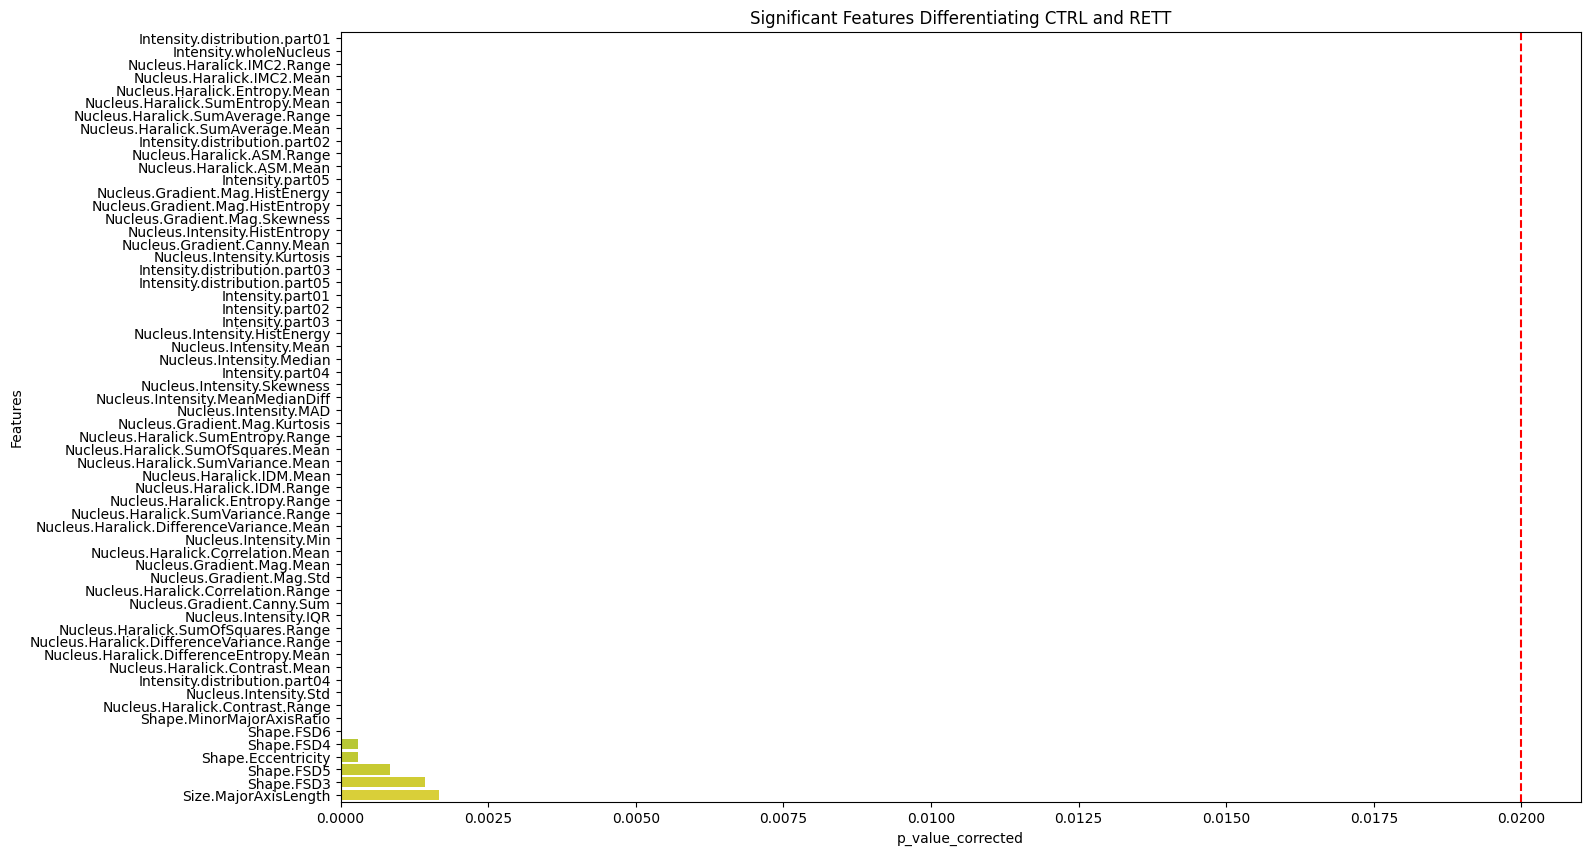

📊 Mann-Whitney U test
significant_features:  60
                                  Feature       p_value   p_corrected
            Intensity.distribution.part01  0.000000e+00  0.000000e+00
            Nucleus.Haralick.Entropy.Mean  0.000000e+00  0.000000e+00
         Nucleus.Haralick.SumEntropy.Mean  0.000000e+00  0.000000e+00
        Nucleus.Haralick.SumAverage.Range  0.000000e+00  0.000000e+00
         Nucleus.Haralick.SumAverage.Mean  0.000000e+00  0.000000e+00
            Intensity.distribution.part02  0.000000e+00  0.000000e+00
                   Intensity.wholeNucleus  0.000000e+00  0.000000e+00
                         Intensity.part05  0.000000e+00  0.000000e+00
               Nucleus.Haralick.ASM.Range  0.000000e+00  0.000000e+00
                Nucleus.Haralick.ASM.Mean  0.000000e+00  0.000000e+00
            Nucleus.Gradient.Mag.Skewness  0.000000e+00  0.000000e+00
            Nucleus.Intensity.HistEntropy  0.000000e+00  0.000000e+00
             Nucleus.Intensity.HistEnergy 

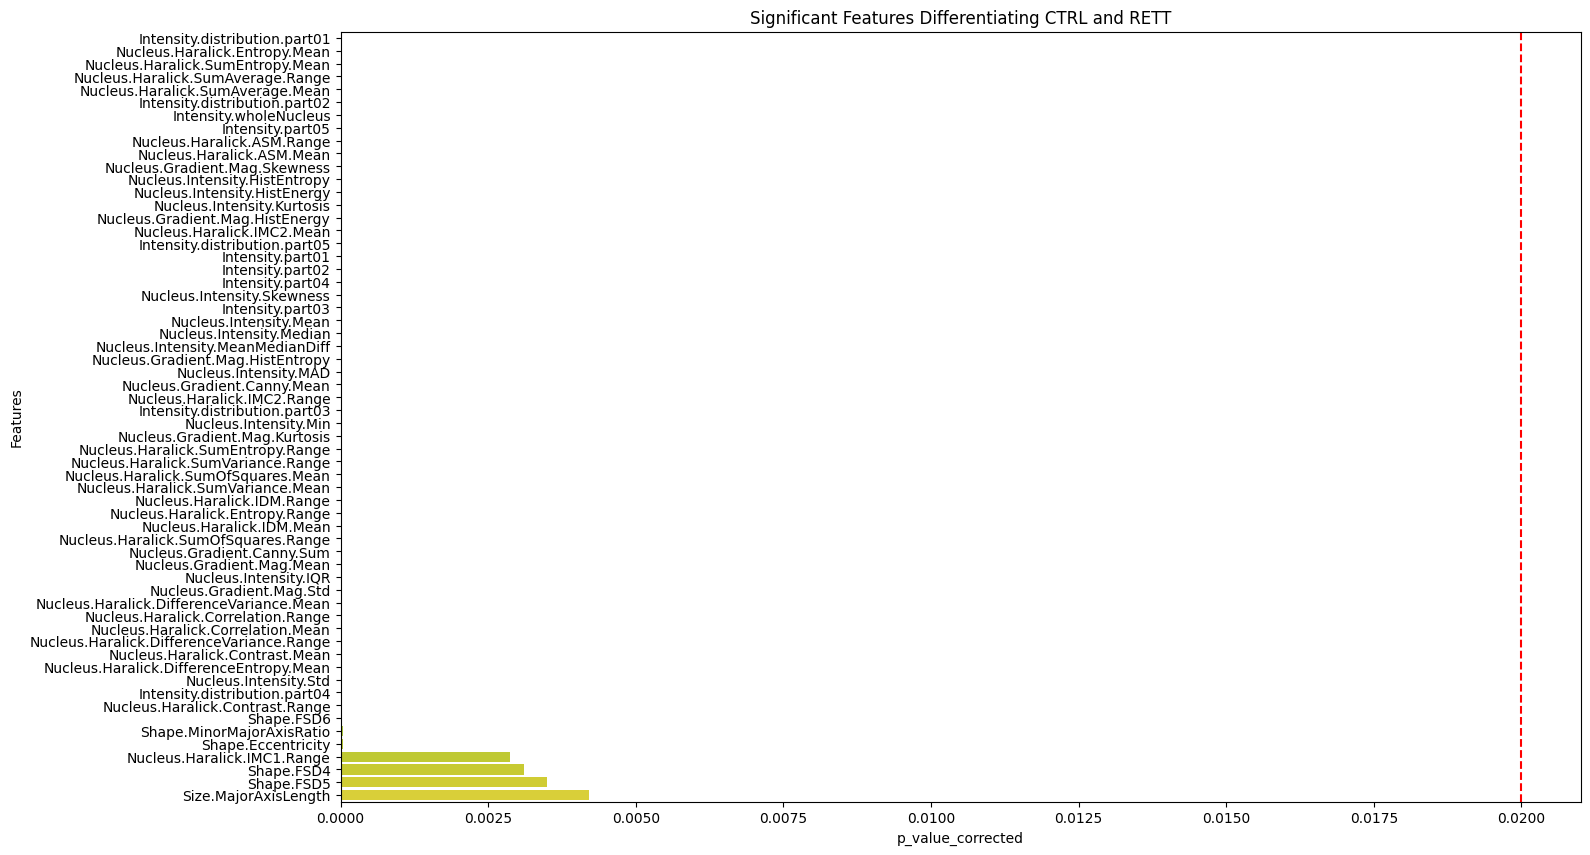

####################  🦠 Feature_ScoreCAM/features_RETT_H3K27ac_Resnet10_noavg_ScoreCAM.csv   ####################
####################  🧫 Feature_ScoreCAM/features_CTRL_H3K27ac_Resnet10_noavg_ScoreCAM.csv   ####################
load csv (3486, 73), (1567, 73)
📊 ttest
significant_features:  63
                                  Feature       p_value   p_corrected
           Nucleus.Haralick.Entropy.Range  0.000000e+00  0.000000e+00
            Nucleus.Haralick.Entropy.Mean  0.000000e+00  0.000000e+00
         Nucleus.Gradient.Mag.HistEntropy  0.000000e+00  0.000000e+00
                    Nucleus.Intensity.MAD  0.000000e+00  0.000000e+00
                    Nucleus.Intensity.IQR  0.000000e+00  0.000000e+00
               Nucleus.Gradient.Canny.Sum  0.000000e+00  0.000000e+00
              Nucleus.Gradient.Canny.Mean  0.000000e+00  0.000000e+00
                 Nucleus.Gradient.Mag.Std  0.000000e+00  0.000000e+00
           Nucleus.Haralick.Contrast.Mean  0.000000e+00  0.000000e+00
      

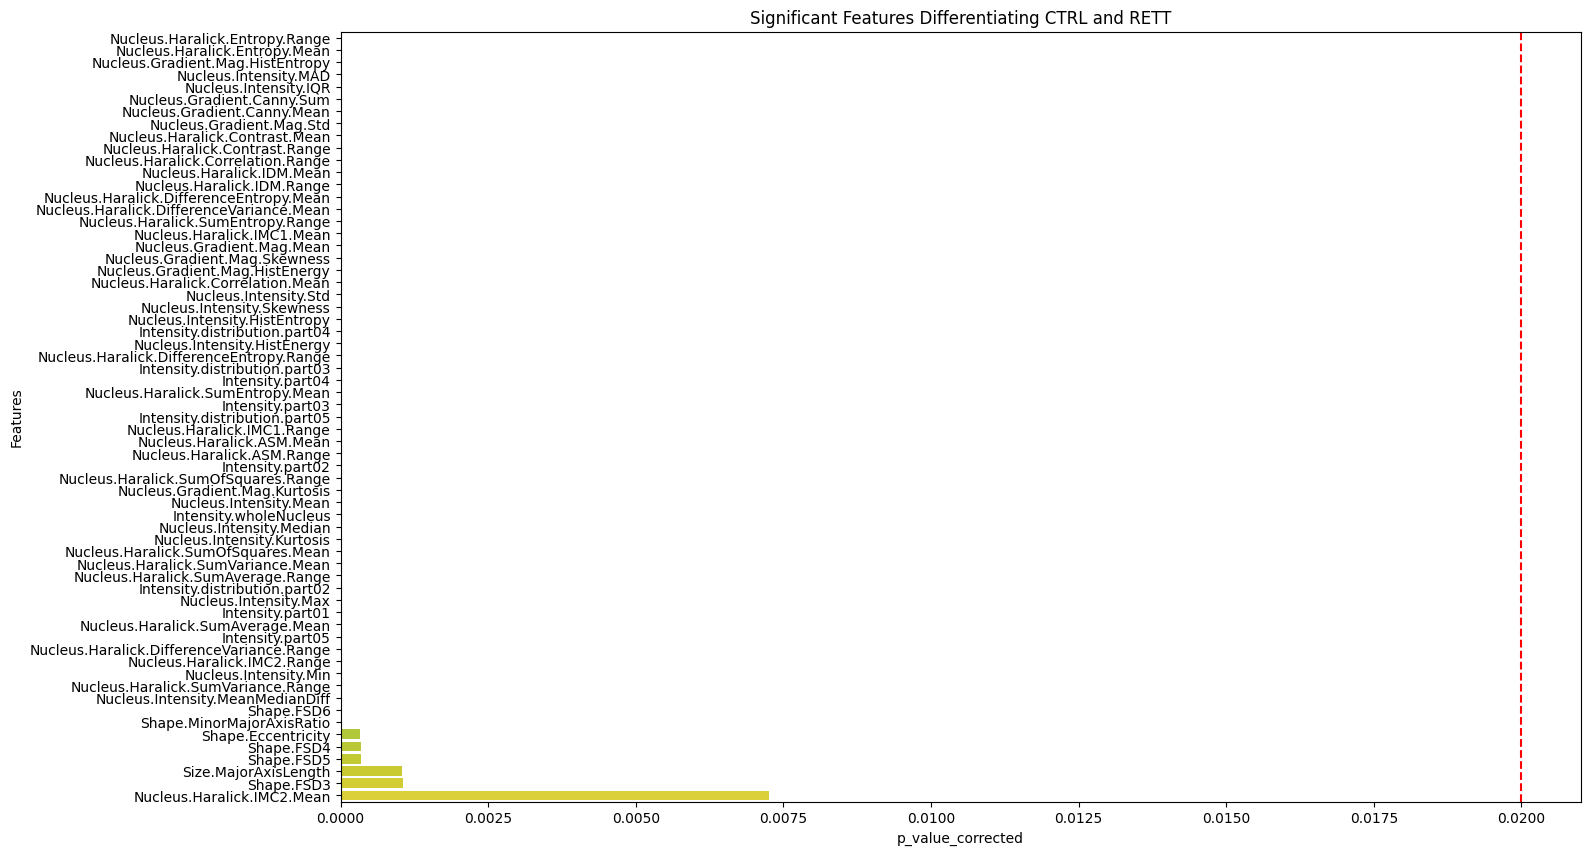

📊 Mann-Whitney U test
significant_features:  62
                                  Feature       p_value   p_corrected
          Nucleus.Gradient.Mag.HistEnergy  0.000000e+00  0.000000e+00
               Nucleus.Haralick.IDM.Range  0.000000e+00  0.000000e+00
          Nucleus.Haralick.Contrast.Range  0.000000e+00  0.000000e+00
           Nucleus.Haralick.Contrast.Mean  0.000000e+00  0.000000e+00
                Nucleus.Haralick.ASM.Mean  0.000000e+00  0.000000e+00
              Nucleus.Gradient.Canny.Mean  0.000000e+00  0.000000e+00
               Nucleus.Gradient.Canny.Sum  0.000000e+00  0.000000e+00
  Nucleus.Haralick.DifferenceEntropy.Mean  0.000000e+00  0.000000e+00
         Nucleus.Gradient.Mag.HistEntropy  0.000000e+00  0.000000e+00
            Nucleus.Gradient.Mag.Kurtosis  0.000000e+00  0.000000e+00
            Nucleus.Gradient.Mag.Skewness  0.000000e+00  0.000000e+00
                 Nucleus.Gradient.Mag.Std  0.000000e+00  0.000000e+00
                Nucleus.Gradient.Mag.Mean 

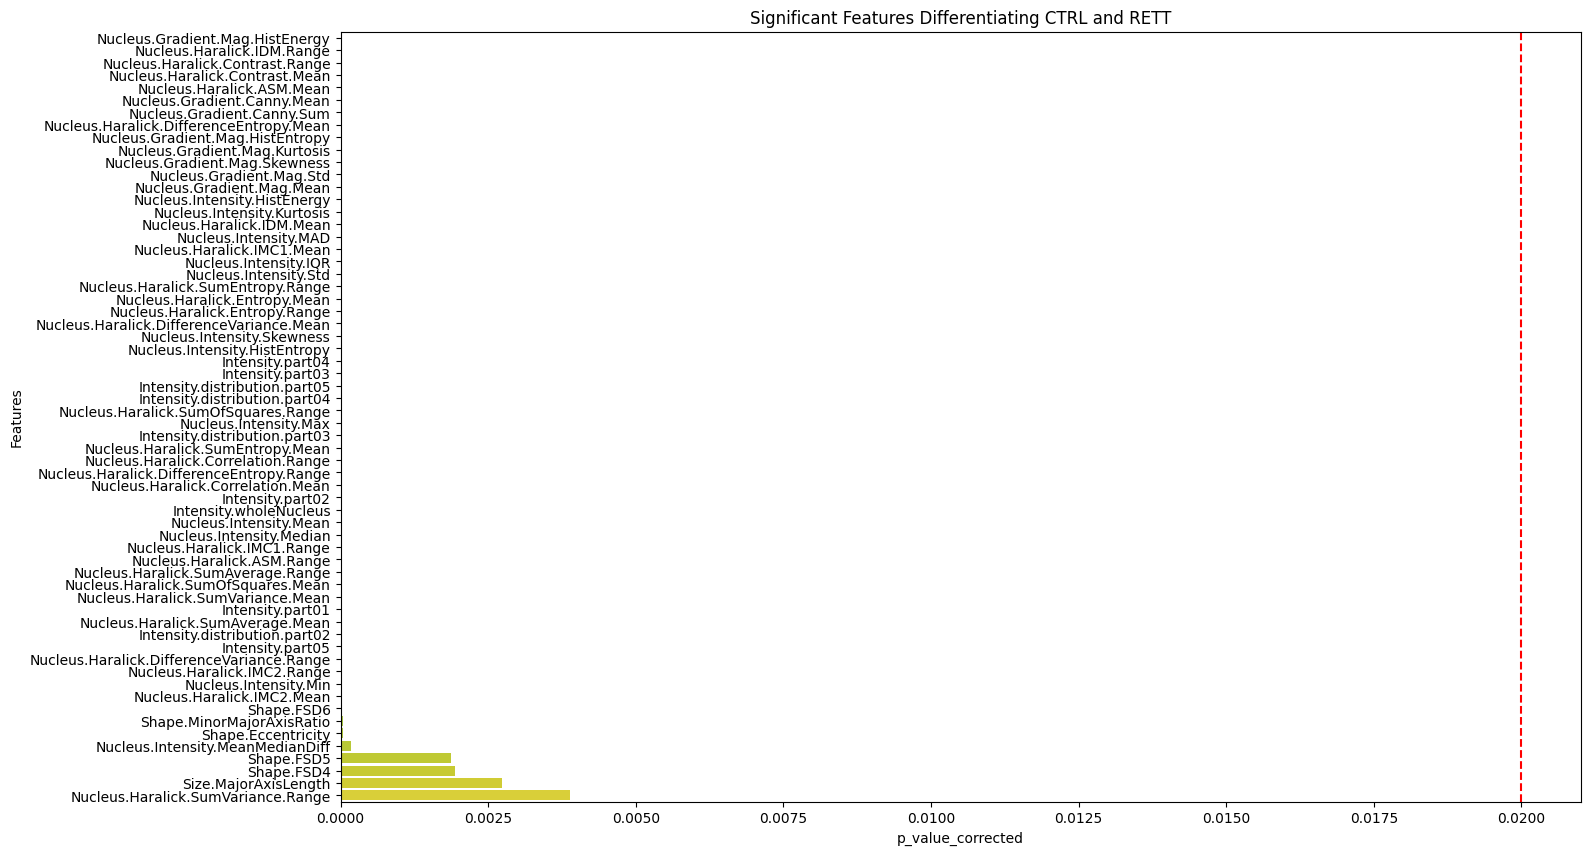

####################  🦠 Feature_ScoreCAM/features_RETT_CTCF_Resnet10_noavg_ScoreCAM.csv   ####################
####################  🧫 Feature_ScoreCAM/features_CTRL_CTCF_Resnet10_noavg_ScoreCAM.csv   ####################
load csv (3518, 73), (1592, 73)
📊 ttest
significant_features:  63
                                  Feature       p_value   p_corrected
        Nucleus.Haralick.Correlation.Mean  0.000000e+00  0.000000e+00
            Nucleus.Intensity.HistEntropy  0.000000e+00  0.000000e+00
             Nucleus.Intensity.HistEnergy  0.000000e+00  0.000000e+00
               Nucleus.Haralick.IMC2.Mean  0.000000e+00  0.000000e+00
       Nucleus.Haralick.Correlation.Range  0.000000e+00  0.000000e+00
       Nucleus.Haralick.SumOfSquares.Mean  0.000000e+00  0.000000e+00
                    Nucleus.Intensity.Std  0.000000e+00  0.000000e+00
              Nucleus.Haralick.IMC2.Range  0.000000e+00  0.000000e+00
         Nucleus.Haralick.SumEntropy.Mean  0.000000e+00  0.000000e+00
        Nucl

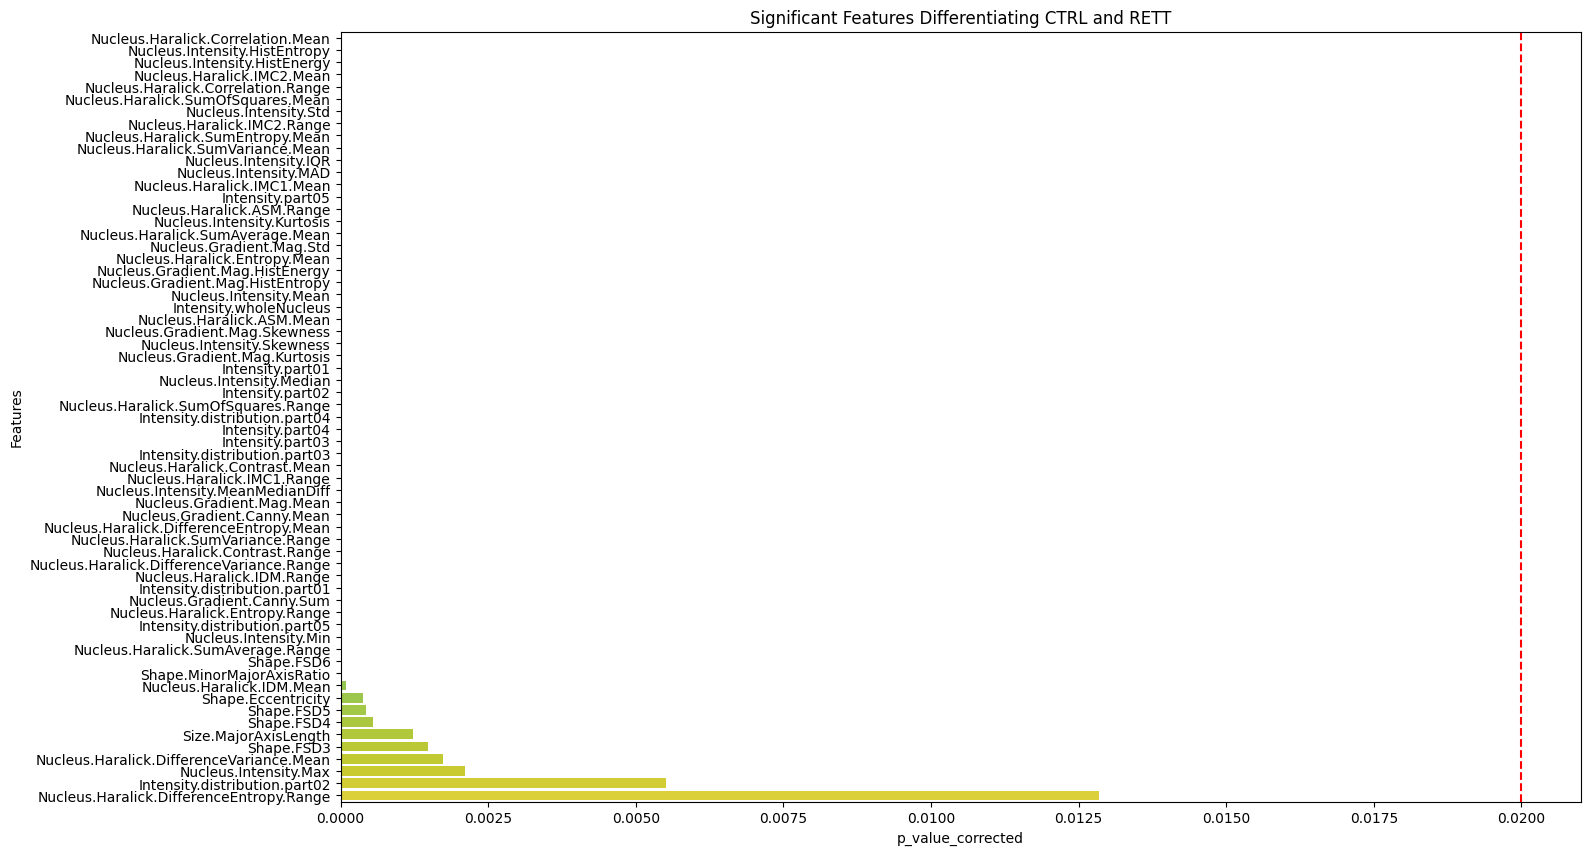

📊 Mann-Whitney U test
significant_features:  62
                                  Feature       p_value   p_corrected
        Nucleus.Haralick.Correlation.Mean  0.000000e+00  0.000000e+00
                    Nucleus.Intensity.Std  0.000000e+00  0.000000e+00
       Nucleus.Haralick.Correlation.Range  0.000000e+00  0.000000e+00
       Nucleus.Haralick.SumOfSquares.Mean  0.000000e+00  0.000000e+00
               Nucleus.Haralick.IMC2.Mean  0.000000e+00  0.000000e+00
              Nucleus.Haralick.IMC2.Range  0.000000e+00  0.000000e+00
        Nucleus.Haralick.SumVariance.Mean  0.000000e+00  0.000000e+00
            Nucleus.Intensity.HistEntropy 3.935021e-306 3.590707e-305
                    Nucleus.Intensity.IQR 1.288644e-301 1.045233e-300
                    Nucleus.Intensity.MAD 4.284119e-277 3.127407e-276
             Nucleus.Intensity.HistEnergy 9.078755e-272 6.024992e-271
         Nucleus.Haralick.SumEntropy.Mean 1.910311e-246 1.162106e-245
                         Intensity.part05 

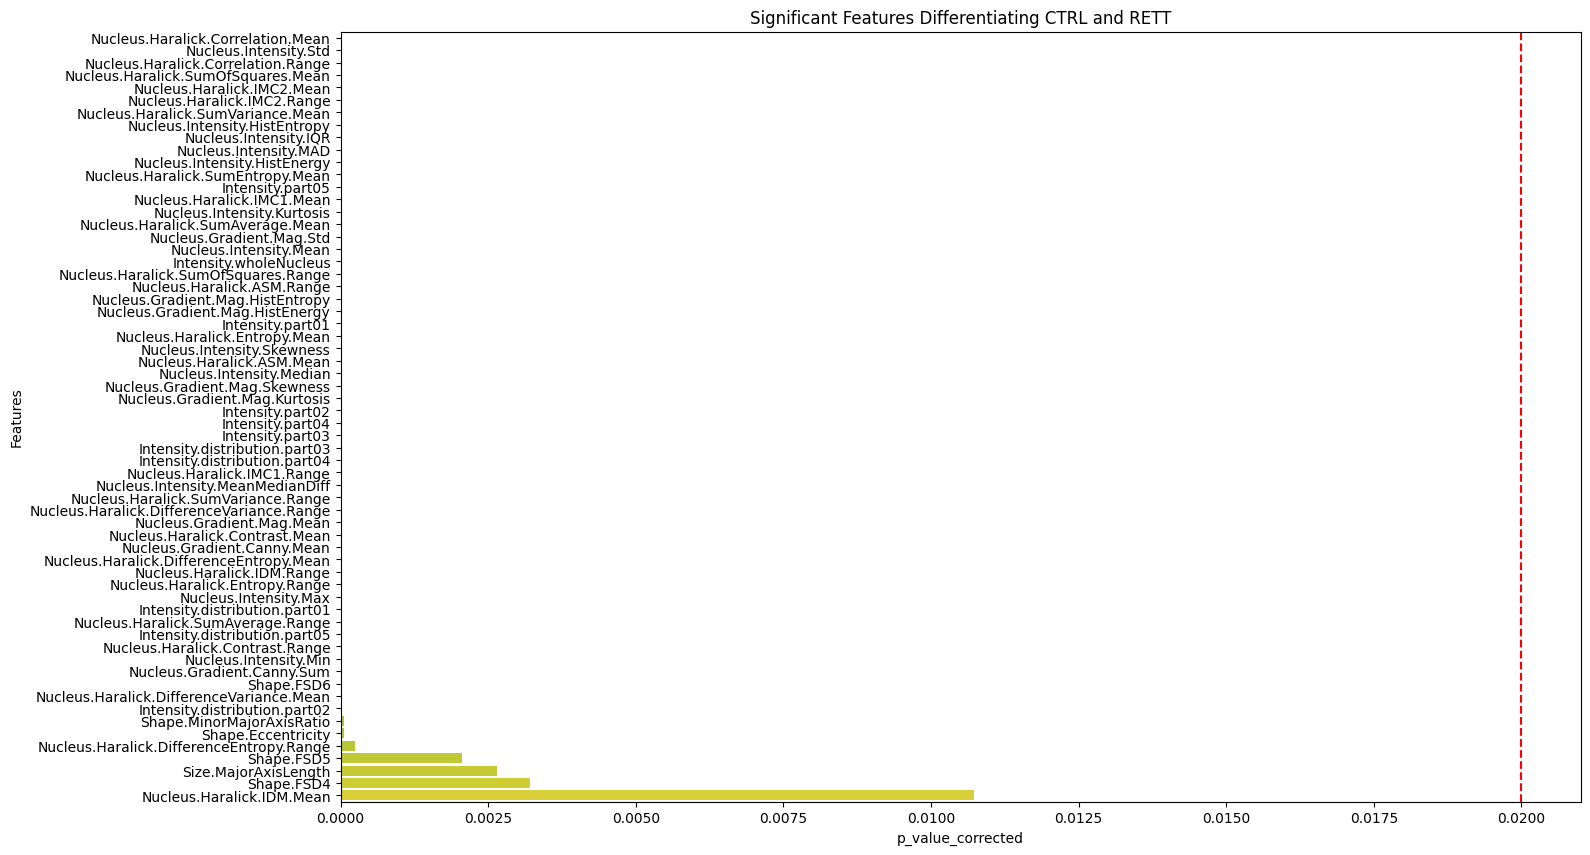

####################  🦠 Feature_ScoreCAM/features_RETT_Dapi_Resnet10_noavg_ScoreCAM.csv   ####################
####################  🧫 Feature_ScoreCAM/features_CTRL_Dapi_Resnet10_noavg_ScoreCAM.csv   ####################
load csv (3484, 73), (1517, 73)
📊 ttest
significant_features:  64
                                  Feature       p_value   p_corrected
         Nucleus.Haralick.SumEntropy.Mean  0.000000e+00  0.000000e+00
                   Intensity.wholeNucleus  0.000000e+00  0.000000e+00
               Nucleus.Intensity.Skewness  0.000000e+00  0.000000e+00
            Intensity.distribution.part05  0.000000e+00  0.000000e+00
                         Intensity.part01  0.000000e+00  0.000000e+00
                         Intensity.part02  0.000000e+00  0.000000e+00
                         Intensity.part03  0.000000e+00  0.000000e+00
                         Intensity.part04  0.000000e+00  0.000000e+00
         Nucleus.Haralick.SumAverage.Mean  0.000000e+00  0.000000e+00
            

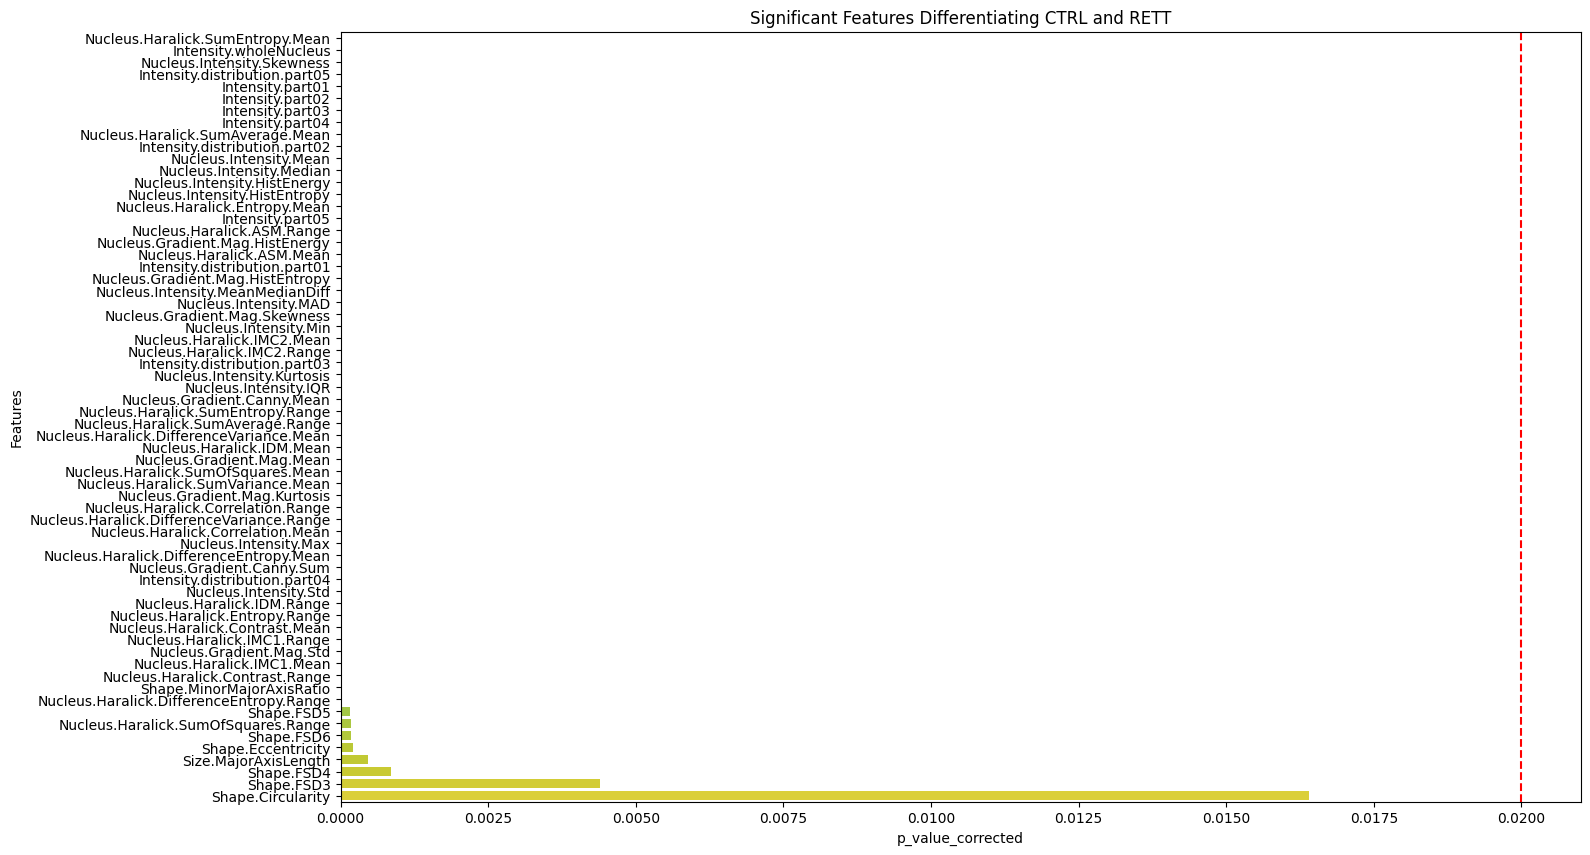

📊 Mann-Whitney U test
significant_features:  62
                                  Feature       p_value   p_corrected
                   Intensity.wholeNucleus  0.000000e+00  0.000000e+00
            Intensity.distribution.part05  0.000000e+00  0.000000e+00
                         Intensity.part01  0.000000e+00  0.000000e+00
                         Intensity.part02  0.000000e+00  0.000000e+00
                         Intensity.part03  0.000000e+00  0.000000e+00
                   Nucleus.Intensity.Mean  0.000000e+00  0.000000e+00
                 Nucleus.Intensity.Median  0.000000e+00  0.000000e+00
                         Intensity.part04  0.000000e+00  0.000000e+00
         Nucleus.Haralick.SumAverage.Mean  0.000000e+00  0.000000e+00
               Nucleus.Intensity.Skewness 1.949258e-287 1.422958e-286
                    Nucleus.Intensity.Min 1.044985e-281 6.934902e-281
         Nucleus.Haralick.SumEntropy.Mean 8.135945e-272 4.949367e-271
                         Intensity.part05 

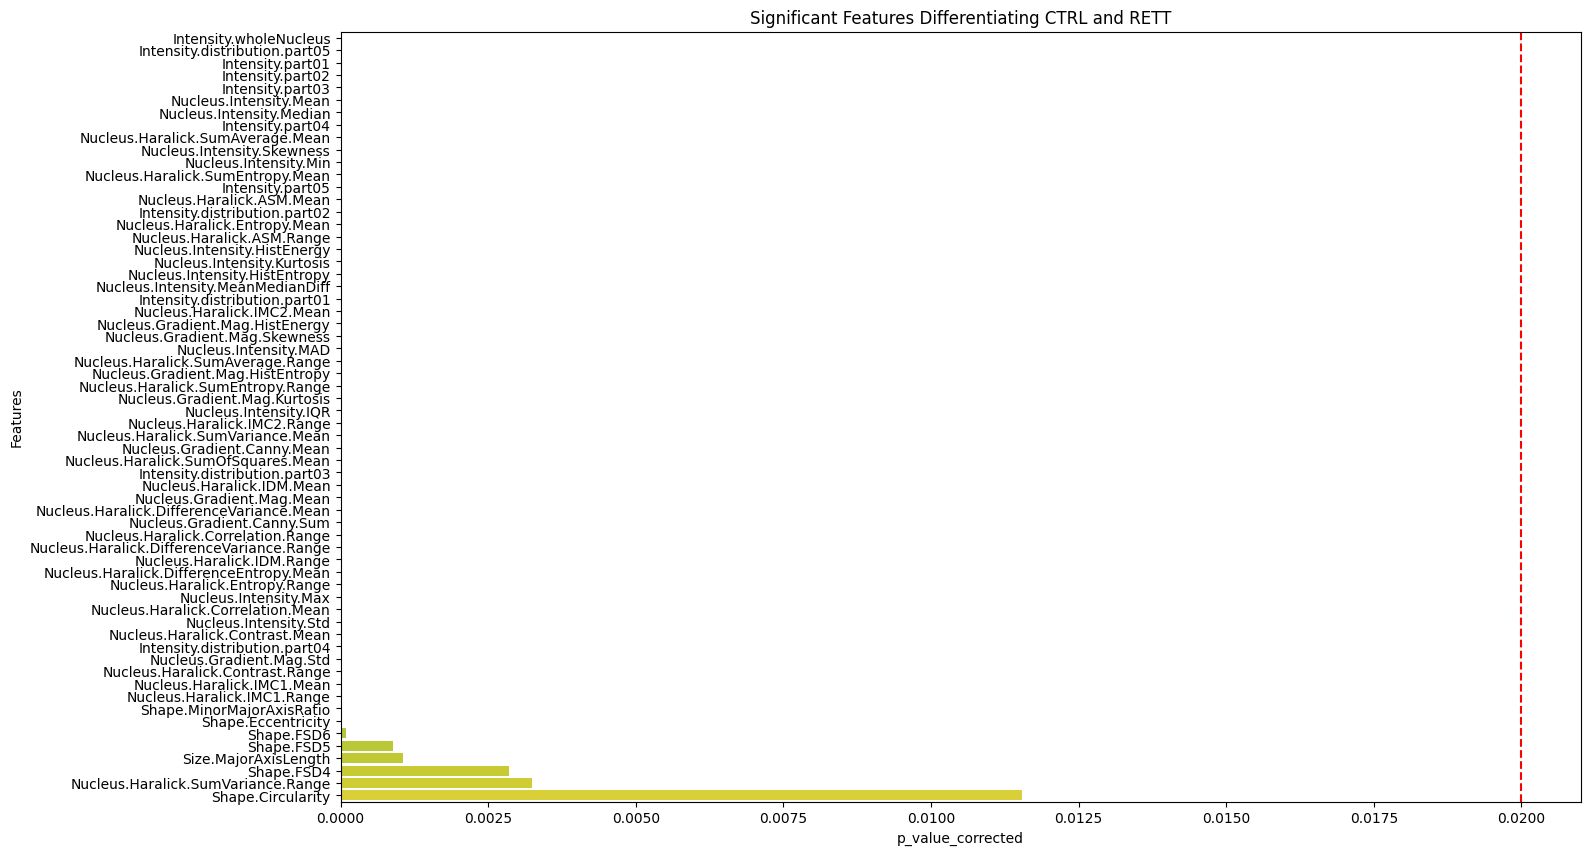

In [77]:
# Feature_GradCAM and Feature_ScoreCAM
for loadpath in ["Feature_ScoreCAM"]:
    for stain_type in ["All", "H3K27ac", "CTCF", "Dapi"]:
        
        savename = f"Feature_{stain_type}"
        
        df_combined, df_RETT, df_CTRL = loadcsv(loadpath, stain_type)

        validate_ttest(df_combined, df_RETT, df_CTRL, loadpath, savename)

        validate_mannwhitneyutest(df_combined, df_RETT, df_CTRL, loadpath, savename)

In [ ]:
# Feature_GradCAM and Feature_ScoreCAM
for loadpath in ["Feature_ScoreCAM"]:
    for stain_type in ["All", "H3K27ac", "CTCF", "Dapi"]:
        
        savename = f"Feature_{stain_type}"
        
        df_combined, df_RETT, df_CTRL = loadcsv_Standard(loadpath, stain_type)
        
        validate_pca(df_combined, df_RETT, df_CTRL, loadpath, savename)

# Feature image

####################  🦠 Feature_image/features_RETT_H3K27ac.csv   ####################
####################  🧫 Feature_image/features_CTRL_H3K27ac.csv   ####################
load csv (3595, 73), (1723, 73)
📊 ttest
significant_features:  59
                                  Feature       p_value   p_corrected
         Nucleus.Intensity.MeanMedianDiff 5.048642e-127 3.685509e-125
               Nucleus.Intensity.Skewness 6.170130e-126 2.252098e-124
              Nucleus.Gradient.Canny.Mean  6.817652e-93  1.658962e-91
               Nucleus.Gradient.Canny.Sum  9.730107e-92  1.775744e-90
                Nucleus.Gradient.Mag.Mean  3.176850e-89  4.638201e-88
                Nucleus.Haralick.IDM.Mean  5.063888e-87  6.161064e-86
                    Nucleus.Intensity.Max  1.125970e-86  1.174226e-85
             Nucleus.Intensity.HistEnergy  1.105317e-78  1.008602e-77
            Nucleus.Intensity.HistEntropy  2.162931e-77  1.754378e-76
 Nucleus.Haralick.DifferenceVariance.Mean  1.046332e-76  7.6

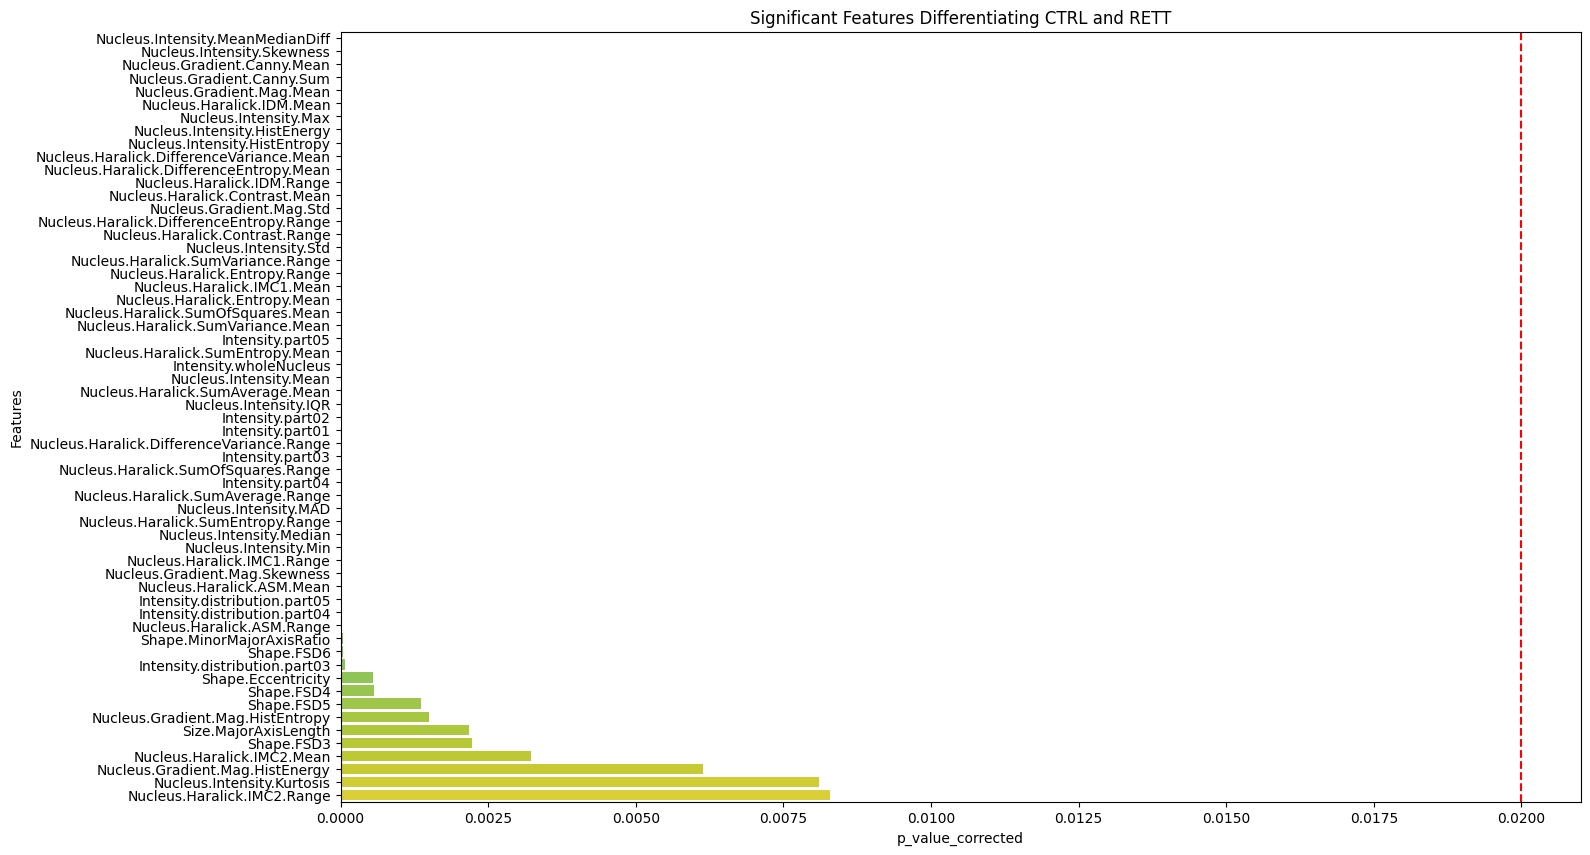

####################  🦠 Feature_image/features_RETT_CTCF.csv   ####################
####################  🧫 Feature_image/features_CTRL_CTCF.csv   ####################
load csv (3595, 73), (1723, 73)
📊 ttest
significant_features:  56
                                  Feature       p_value   p_corrected
             Nucleus.Intensity.HistEnergy 8.108916e-164 5.919508e-162
               Nucleus.Intensity.Skewness 1.189905e-160 4.343152e-159
            Nucleus.Intensity.HistEntropy 5.163929e-148 1.256556e-146
            Intensity.distribution.part05  5.895786e-89  1.075981e-87
              Nucleus.Haralick.IMC2.Range  7.683323e-71  1.121765e-69
            Intensity.distribution.part02  8.108699e-66  9.865584e-65
            Intensity.distribution.part04  7.137101e-49  7.442977e-48
        Nucleus.Haralick.Correlation.Mean  5.058039e-40  4.469039e-39
                         Intensity.part05  5.509774e-40  4.469039e-39
       Nucleus.Haralick.Correlation.Range  9.665881e-39  7.056093e

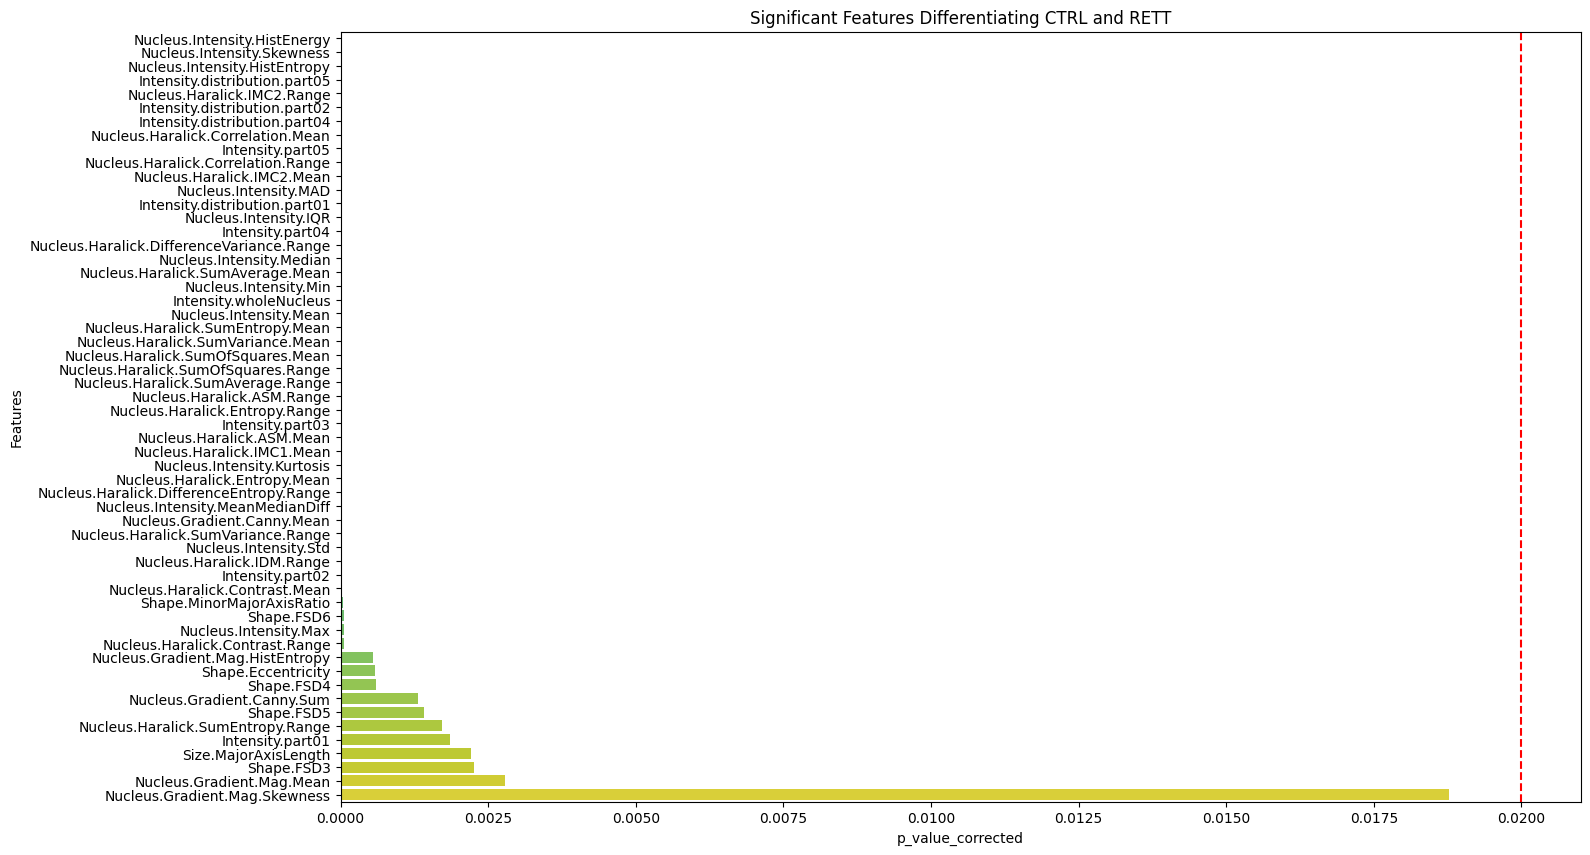

####################  🦠 Feature_image/features_RETT_Dapi.csv   ####################
####################  🧫 Feature_image/features_CTRL_Dapi.csv   ####################
load csv (3595, 73), (1723, 73)
📊 ttest
significant_features:  58
                                  Feature       p_value   p_corrected
                         Intensity.part03 8.520717e-196 6.220123e-194
                         Intensity.part02 1.381534e-194 5.042598e-193
                         Intensity.part01 2.161446e-194 5.259517e-193
                         Intensity.part04 7.036998e-190 1.284252e-188
                   Nucleus.Intensity.Mean 4.802859e-188 5.843478e-187
                   Intensity.wholeNucleus 4.802777e-188 5.843478e-187
         Nucleus.Haralick.SumAverage.Mean 8.658449e-188 9.029525e-187
                 Nucleus.Intensity.Median 1.959602e-187 1.788137e-186
                         Intensity.part05 6.936344e-177 5.626146e-176
                 Nucleus.Gradient.Mag.Std 3.538511e-169 2.583113e-

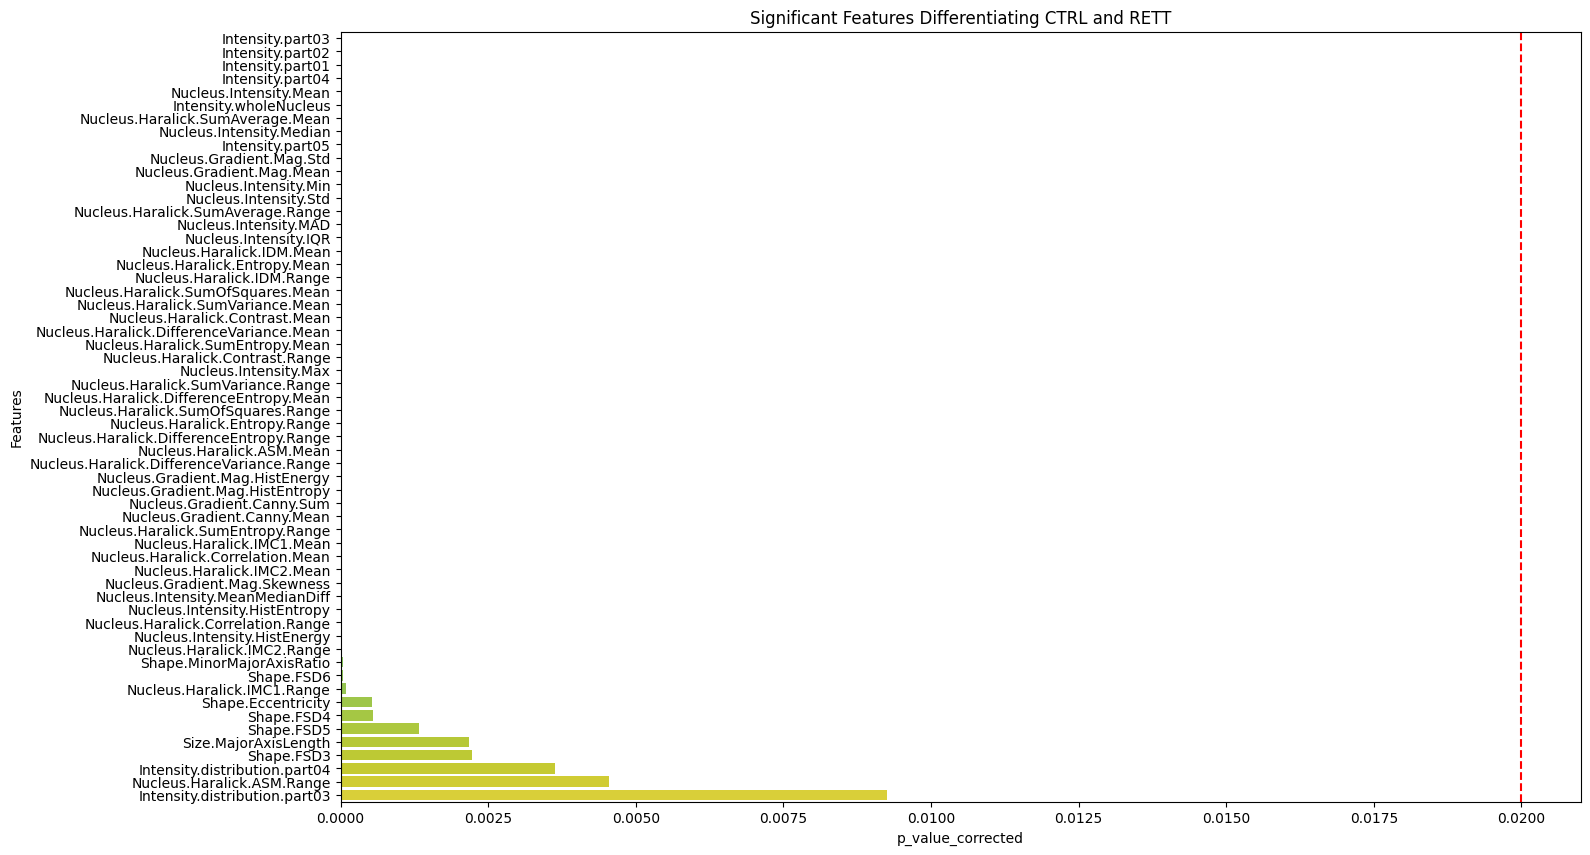

In [75]:
# Feature image
for loadpath in ["Feature_image"]:
    for stain_type in ["H3K27ac", "CTCF", "Dapi"]:
        savename = f"Feature_{stain_type}"
        df_combined, df_RETT, df_CTRL = loadcsv(loadpath, stain_type)
        
        validate_ttest(df_combined, df_RETT, df_CTRL, loadpath, savename)

        validate_mannwhitneyutest(df_combined, df_RETT, df_CTRL, loadpath, savename)

In [ ]:
# Feature image
for loadpath in ["Feature_image"]:
    for stain_type in ["H3K27ac", "CTCF", "Dapi"]:
        savename = f"Feature_{stain_type}"
        df_combined, df_RETT, df_CTRL = loadcsv(loadpath, stain_type)
        
        validate_pca(df_combined, df_RETT, df_CTRL, loadpath, savename)

# BOX 箱型图

In [46]:
def validata_boxplot(data_all, feature):
    # 假设 data_all 是之前整理好的 DataFrame
    unique_stains = data_all['Stain_Type'].unique()  # 获取所有染色类型
    p_values = []
    # 计算每种染色类型的 p 值
    for stain in unique_stains:
        group_ctrl = data_all[(data_all['State'] == 'CTRL') & (data_all['Stain_Type'] == stain)][feature]
        group_rett = data_all[(data_all['State'] == 'RETT') & (data_all['Stain_Type'] == stain)][feature]
        _, p_val = ttest_ind(group_ctrl, group_rett)
        p_values.append(p_val)
    for i in range(len(unique_stains)):
        print(f"p-value {unique_stains[i]}: {p_values[i]}")

    # 设置颜色
    palette_colors = {"CTRL": sns.color_palette(palette='bwr')[0], 
                      "RETT": sns.color_palette(palette='Pastel1')[0]}  # CTRL 使用绿色，RETT 使用紫色
    # 绘制箱型图
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Stain_Type', y=feature, hue='State', data=data_all, palette=palette_colors)
    plt.title(f'{feature} with Stains and Cell States')
    plt.ylabel(f'{feature}')
    plt.xlabel('Stain Type')
    plt.legend(title='Cell State')
    plt.savefig(f'{loadpath}/{loadpath}_{feature}.png', dpi=300)
    plt.show()

## ScoreCAM Box plot

####################  🦠 Feature_ScoreCAM/features_RETT_All_Resnet10_noavg_ScoreCAM.csv   ####################
####################  🧫 Feature_ScoreCAM/features_CTRL_All_Resnet10_noavg_ScoreCAM.csv   ####################
load csv (3554, 73), (1701, 73)
####################  🦠 Feature_ScoreCAM/features_RETT_H3K27ac_Resnet10_noavg_ScoreCAM.csv   ####################
####################  🧫 Feature_ScoreCAM/features_CTRL_H3K27ac_Resnet10_noavg_ScoreCAM.csv   ####################
load csv (3486, 73), (1567, 73)
####################  🦠 Feature_ScoreCAM/features_RETT_CTCF_Resnet10_noavg_ScoreCAM.csv   ####################
####################  🧫 Feature_ScoreCAM/features_CTRL_CTCF_Resnet10_noavg_ScoreCAM.csv   ####################
load csv (3518, 73), (1592, 73)
####################  🦠 Feature_ScoreCAM/features_RETT_Dapi_Resnet10_noavg_ScoreCAM.csv   ####################
####################  🧫 Feature_ScoreCAM/features_CTRL_Dapi_Resnet10_noavg_ScoreCAM.csv   ####################
load csv (34

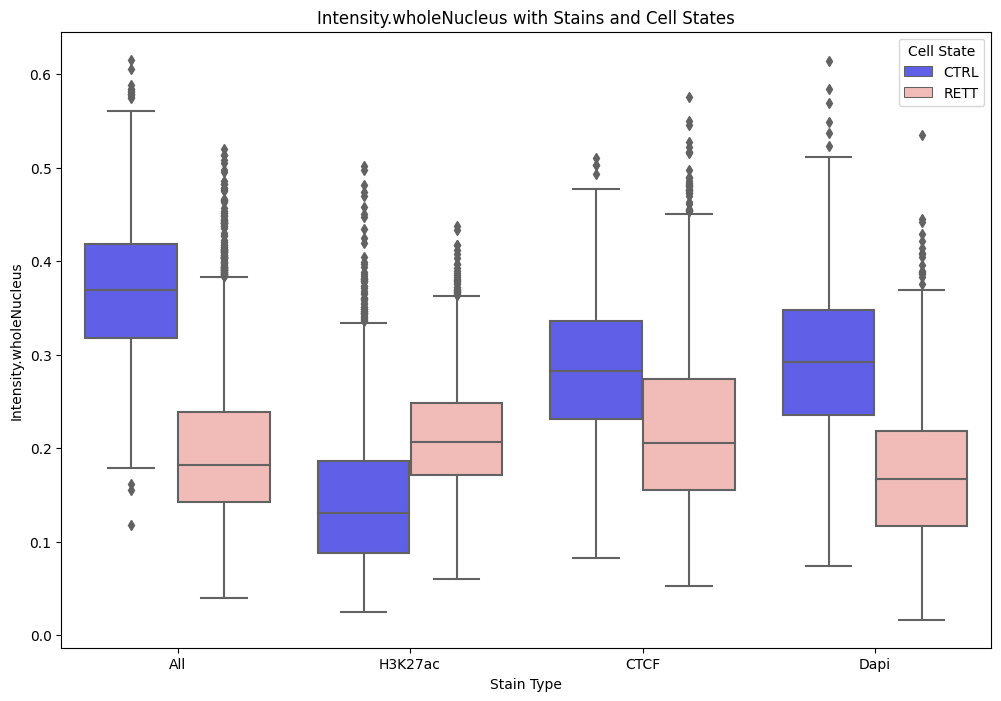

💠 Fearure - Intensity.distribution.part05
p-value All: 0.0
p-value H3K27ac: 0.0
p-value CTCF: 1.1698591402454326e-22
p-value Dapi: 1.6499719326601093e-195


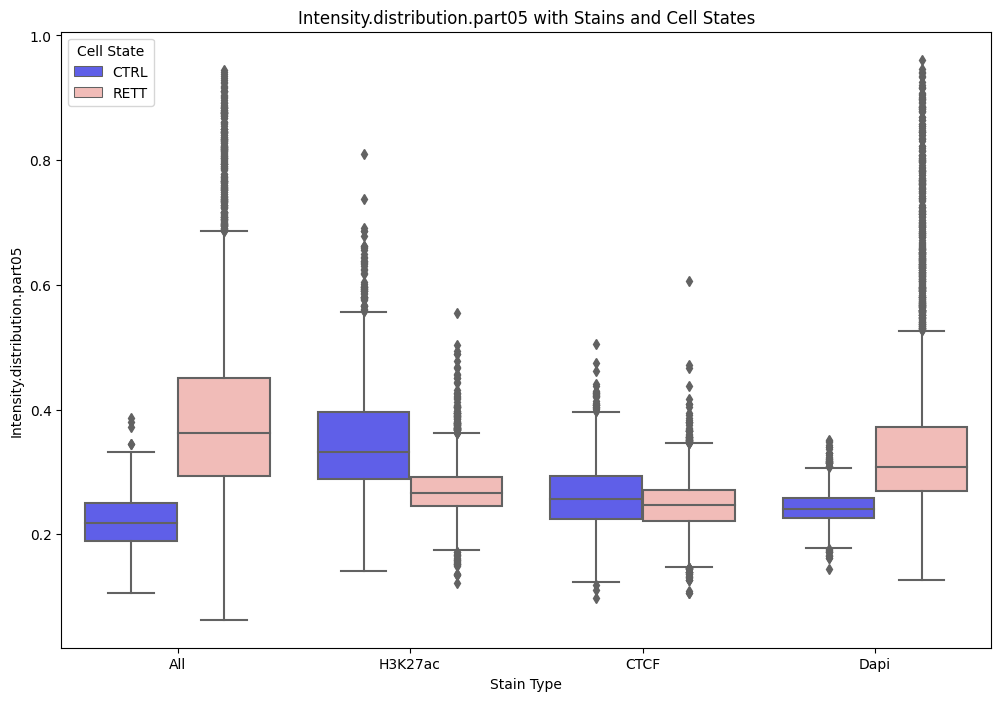

In [49]:
# 创建一个空的 DataFrame 用于存放所有数据
data_all = pd.DataFrame()

for loadpath in ["Feature_ScoreCAM"]:
    for stain_type in ["All", "H3K27ac", "CTCF", "Dapi"]:
        # 假设 loadcsv 函数返回的 df_combined 已包含状态标签
        df_combined, df_RETT, df_CTRL = loadcsv(loadpath, stain_type)
        df_combined['Stain_Type'] = stain_type  # 添加染色类型列
        data_all = pd.concat([data_all, df_combined])  # 合并数据

# features = df_CTRL.columns.tolist()
# features = features[-11:-1]
features = ["Intensity.wholeNucleus", "Intensity.distribution.part05"]
print(features)
for feature in features:
    print(f"💠 Fearure - {feature}")
    validata_boxplot(data_all, feature)

# Image Box plot

####################  🦠 Feature_image/features_RETT_H3K27ac.csv   ####################
####################  🧫 Feature_image/features_CTRL_H3K27ac.csv   ####################
load csv (3595, 73), (1723, 73)
####################  🦠 Feature_image/features_RETT_CTCF.csv   ####################
####################  🧫 Feature_image/features_CTRL_CTCF.csv   ####################
load csv (3595, 73), (1723, 73)
####################  🦠 Feature_image/features_RETT_Dapi.csv   ####################
####################  🧫 Feature_image/features_CTRL_Dapi.csv   ####################
load csv (3595, 73), (1723, 73)
['Intensity.wholeNucleus', 'Intensity.distribution.part05']
💠 Fearure - Intensity.wholeNucleus
p-value H3K27ac: 3.930357583956727e-26
p-value CTCF: 9.31600578058228e-24
p-value Dapi: 2.8756561005219086e-125


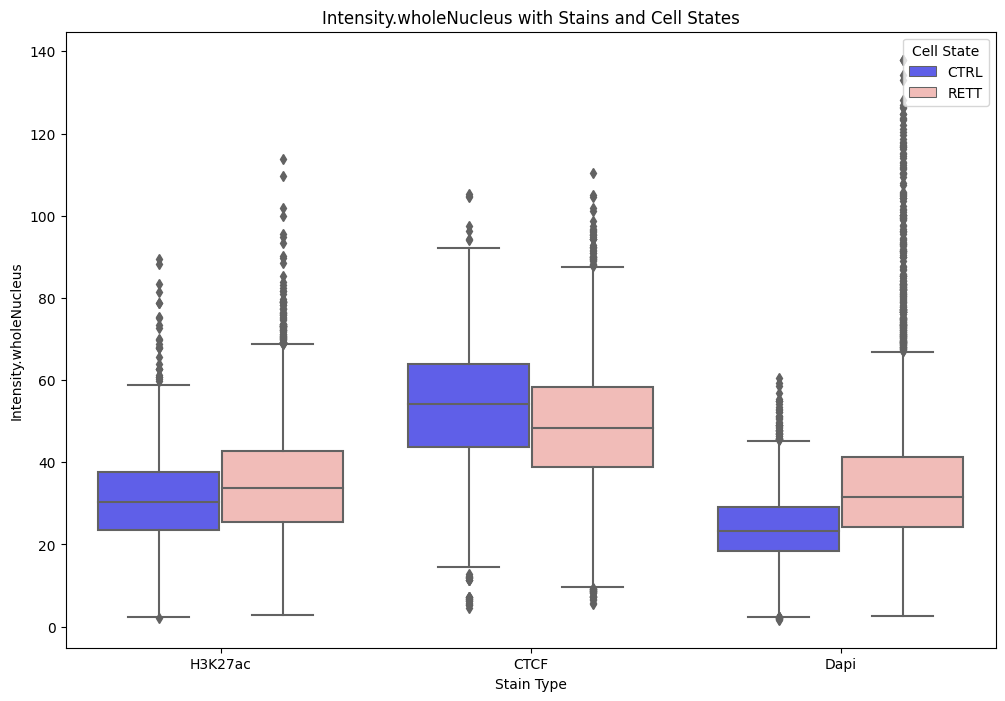

💠 Fearure - Intensity.distribution.part05
p-value H3K27ac: 3.3260863056519206e-06
p-value CTCF: 2.0592217054045046e-96
p-value Dapi: 0.0661450201094295


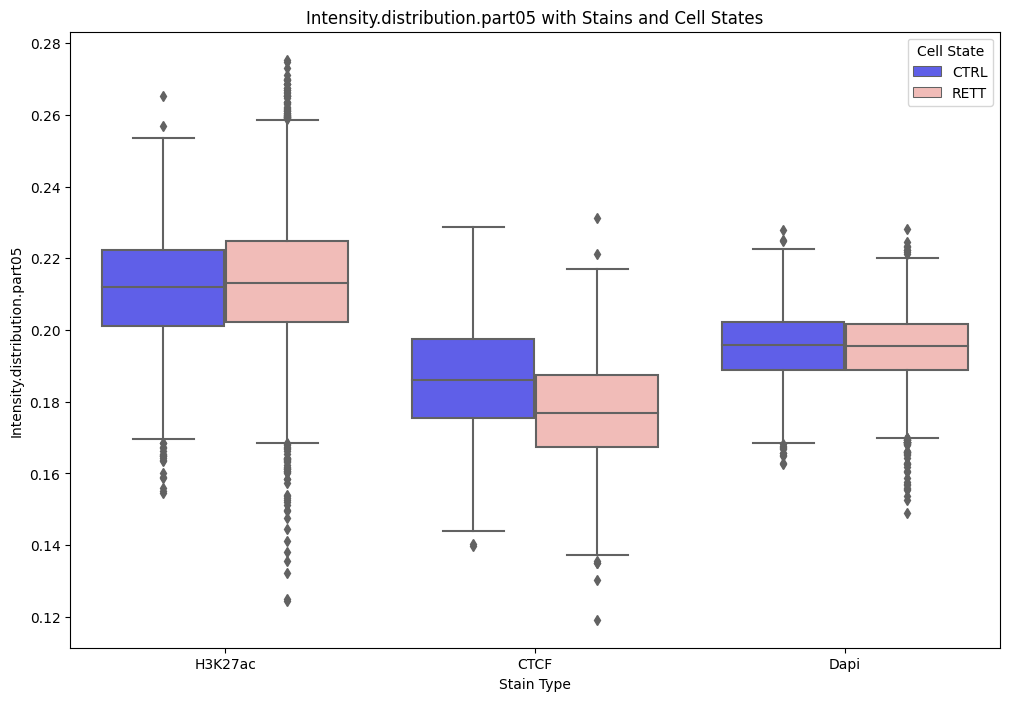

In [36]:
# 创建一个空的 DataFrame 用于存放所有数据
data_all = pd.DataFrame()

for loadpath in ["Feature_image"]:
    for stain_type in ["H3K27ac", "CTCF", "Dapi"]:
        # 假设 loadcsv 函数返回的 df_combined 已包含状态标签
        df_combined, df_RETT, df_CTRL = loadcsv(loadpath, stain_type)
        df_combined['Stain_Type'] = stain_type  # 添加染色类型列
        data_all = pd.concat([data_all, df_combined])  # 合并数据

# features = df_CTRL.columns.tolist()
# features = features[-11:-1]
features = ["Intensity.wholeNucleus", "Intensity.distribution.part05"]
print(features)
for feature in features:
    print(f"💠 Fearure - {feature}")
    validata_boxplot(data_all, feature)